In [60]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import folium
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score
from infomap import Infomap
from community import community_louvain
import networkx.algorithms.community as nx_comm
from sklearn.cluster import SpectralClustering
from tqdm import tqdm


In [89]:
def load_data(trips_file):
    # Load the GeoJSON file into a GeoDataFrame
    zones = gpd.read_file("../data/NYC Taxi Zones.geojson")
    zones = zones[zones['borough'] == 'Manhattan']
    zones = zones.to_crs(epsg=3857)
    zones['centroid'] = zones.geometry.centroid
    zones = zones.drop(columns=['objectid', 'borough'])
    zones['location_id'] = zones['location_id'].astype(int)
    
    # Load the trips df
    trips = pd.read_parquet("../data/all_manhattan_2023_hvfhs.parquet")
    
    # Count occurrences of each location as a PULocationID
    pulocation_counts = trips.groupby("PULocationID").size().reset_index(name="pulocation_count")
    
    # Count occurrences of each location as a DOLocationID
    dolocation_counts = trips.groupby("DOLocationID").size().reset_index(name="dolocation_count")
    
    # Merge these counts into the gdf DataFrame
    zones = zones.merge(pulocation_counts, left_on="location_id", right_on="PULocationID", how="left")
    zones = zones.merge(dolocation_counts, left_on="location_id", right_on="DOLocationID", how="left")
    
    # Fill NaN values with 0 (locations that do not appear as pickup/dropoff points)
    zones["pulocation_count"] = zones["pulocation_count"].fillna(0).astype(int)
    zones["dolocation_count"] = zones["dolocation_count"].fillna(0).astype(int)
    
    zones['location_count'] = zones['pulocation_count'] + zones['dolocation_count']
    
    # Drop unnecessary columns added during merge
    zones = zones.drop(columns=["PULocationID", "DOLocationID"])
    
    return trips, zones

trips, zones = load_data("../data/combined_6255123.pkl")
trip_matrix = trips.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='count')
pivot_matrix = trip_matrix.pivot(index='PULocationID', columns='DOLocationID', values='count')

In [90]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49581545 entries, 0 to 49581544
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   request_datetime  datetime64[us]
 1   pickup_datetime   datetime64[us]
 2   dropoff_datetime  datetime64[us]
 3   PULocationID      int64         
 4   DOLocationID      int64         
 5   trip_miles        float64       
 6   trip_time         int64         
 7   fee               float64       
 8   hvfhs             category      
dtypes: category(1), datetime64[us](3), float64(2), int64(3)
memory usage: 3.0 GB


In [47]:
def plot_zone_occurrences():
    plt.figure()
    gdf_sorted = zones.sort_values(by='location_count', ascending=False).reset_index()
    sns.barplot(x=gdf_sorted.index, y=gdf_sorted['location_count'])
    plt.title('Zone Occurrences', fontsize=16)
    plt.xlabel('Zone', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks([])
    plt.show()
    
def plot_trip_heatmap(_trip_matrix, _pivot_matrix):
    # Calculate total trip counts for sorting
    pickup_totals = _trip_matrix.groupby('PULocationID')['count'].sum().sort_values(ascending=False).index
    dropoff_totals = _trip_matrix.groupby('DOLocationID')['count'].sum().sort_values(ascending=False).index
    
    # Reorder rows and columns based on sorted totals
    pivot_matrix_sorted = _pivot_matrix.loc[pickup_totals, dropoff_totals]
    
    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        pivot_matrix_sorted, 
        cmap='YlGnBu', 
        linewidths=0.5, 
        cbar_kws={'label': 'Trip Counts'}
    )
    plt.title("Heatmap of Trips (Sorted by Total Counts)")
    plt.xlabel("Dropoff Location ID")
    plt.ylabel("Pickup Location ID")
    plt.show()
    
def plot_zone_heatmap():
    # Create a colormap
    unique_values = zones['location_count'].unique()
    unique_values.sort()
    norm = mcolors.Normalize(vmin=0, vmax=len(unique_values))
    color_dict = {val: mcolors.rgb2hex(plt.cm.coolwarm(norm(i))) for i, val in enumerate(unique_values)}
    zones['color'] = zones['location_count'].map(color_dict)
    
    # Create the base map centered on Manhattan
    manhattan_map = folium.Map(location=[40.7831, -73.9712], zoom_start=12, tiles='CartoDB positron')
    
    # Add taxi zones (polygons) with tooltips and colors
    folium.GeoJson(
        zones[['geometry', 'zone', 'color']],
        style_function=lambda feature: {
            'fillColor': feature['properties']['color'],
            'color': 'black',
            'weight': 0.5,
            'fillOpacity': 0.7,
        },
        tooltip=folium.GeoJsonTooltip(fields=['zone'], labels=False)  # Tooltip directly on polygons
    ).add_to(manhattan_map)
    
    return manhattan_map

def test_network_visualizations():
    # Create the undirected graph
    G_undirected = nx.Graph()
    
    # Aggregate weights to make the graph undirected
    trip_matrix_undirected = (
        trip_matrix.groupby(
            by=[
                trip_matrix['PULocationID'].combine(trip_matrix['DOLocationID'], min),
                trip_matrix['PULocationID'].combine(trip_matrix['DOLocationID'], max)
            ]
        )['count'].sum().reset_index(name='count')
    )
    
    # Add edges to the graph
    for _, row in trip_matrix_undirected.iterrows():
        if row.iloc[0] != row.iloc[1]:  # Exclude self-loops
            G_undirected.add_edge(row.iloc[0], row.iloc[1], weight=row['count'])
    
    # Layouts and methods of scaling edge weights to test
    layouts = ['spring', 'kamada_kawai', 'shell', 'fruchterman_reingold']
    n = G_undirected.number_of_nodes()
    base_ks = [0.5, 1.0, 2.0]
    ks = [k * (1 / np.sqrt(n)) for k in base_ks]
    scaling_methods = ['linear', 'sqrt', 'log', 'standard', 'minmax']
    threshold_methods = ['median', 'no threshold']  # Additional thresholding method
    multipliers = [1]
    
    # Extract initial edge weights
    edges, weights = zip(*nx.get_edge_attributes(G_undirected, 'weight').items())

    # Create a grid of subplots
    rows = len(scaling_methods) * len(threshold_methods) * len(multipliers)
    fig, axs = plt.subplots(rows, len(layouts), figsize=(len(layouts) * 7, rows * 7))
    
    for i, scaling in enumerate(scaling_methods):
        for j, layout in enumerate(layouts):
            for k_idx, threshold in enumerate(threshold_methods):
                for m, multiplier in enumerate(multipliers):
                    # Precompute scaled weights before layout generation
                    current_weights = list(weights)  # Create a mutable copy
                    if threshold == 'median':
                        median_weight = np.median(current_weights)
                        current_weights = [w if w >= median_weight else 0 for w in current_weights]  # Apply threshold
                    
                    if scaling == 'linear':
                        scaled_weights = current_weights
                    elif scaling == 'sqrt':
                        scaled_weights = [w**0.5 for w in current_weights]
                    elif scaling == 'log':
                        scaled_weights = [np.log(w) if w > 0 else 0 for w in current_weights]  # Log scaling with a positive threshold
                    elif scaling == 'standard':
                        scaler = StandardScaler()
                        scaled_weights = scaler.fit_transform(np.array(current_weights).reshape(-1, 1)).flatten()
                    elif scaling == 'minmax':
                        scaler = MinMaxScaler()
                        scaled_weights = scaler.fit_transform(np.array(current_weights).reshape(-1, 1)).flatten()
                    
                    # Apply multiplier to scaled weights
                    scaled_weights = [w * multiplier for w in scaled_weights]
                    ax = axs[(i * len(threshold_methods) * len(multipliers)) + (k_idx * len(multipliers)) + m, j]
                    
                    # Remove edges with zero weights
                    valid_edges = [(edge, weight) for edge, weight in zip(edges, scaled_weights) if weight > 0]
                    filtered_edges, filtered_weights = zip(*valid_edges) if valid_edges else ([], [])
                    
                    # Update the graph with filtered edges
                    G_filtered = nx.Graph()
                    G_filtered.add_weighted_edges_from([(u, v, w) for (u, v), w in zip(filtered_edges, filtered_weights)])
                    
                    # Generate node positions using the filtered graph
                    if layout == 'spring':
                        pos = nx.spring_layout(G_filtered, k=ks[j], weight='weight', seed=1)
                    elif layout == 'kamada_kawai':
                        pos = nx.kamada_kawai_layout(G_filtered, weight='weight')
                    elif layout == 'shell':
                        pos = nx.shell_layout(G_filtered)
                    elif layout == 'fruchterman_reingold':
                        pos = nx.fruchterman_reingold_layout(G_filtered, weight='weight', seed=1)
                    
                    nx.draw_networkx_nodes(G_filtered, pos, node_size=50, node_color='blue', alpha=0.7, ax=ax)
                    nx.draw_networkx_edges(
                        G_filtered, pos, edgelist=filtered_edges, width=[w / max(filtered_weights) * 5 for w in filtered_weights] if filtered_weights else [], alpha=0.5, ax=ax
                    )
                    ax.set_title(f"{layout.capitalize()} Layout, {scaling.capitalize()} Scaling, {threshold.capitalize()}, Multiplier={multiplier}")
    
    plt.tight_layout()
    plt.show()

def test_fr_visualizations():
    # Create the undirected graph
    G_undirected = nx.Graph()
    
    # Aggregate weights to make the graph undirected
    trip_matrix_undirected = (
        trip_matrix.groupby(
            by=[
                trip_matrix['PULocationID'].combine(trip_matrix['DOLocationID'], min),
                trip_matrix['PULocationID'].combine(trip_matrix['DOLocationID'], max)
            ]
        )['count'].sum().reset_index(name='count')
    )
    
    # Add edges to the graph
    for _, row in trip_matrix_undirected.iterrows():
        if row.iloc[0] != row.iloc[1]:  # Exclude self-loops
            G_undirected.add_edge(row.iloc[0], row.iloc[1], weight=row['count'])
    
    # Layouts and methods of scaling edge weights to test
    scaling_methods = ['linear', 'sqrt', 'log', 'standard', 'minmax']
    base_ks = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
    ks = [k * (1 / np.sqrt(G_undirected.number_of_nodes())) for k in base_ks]
    
    # Extract initial edge weights
    edges, weights = zip(*nx.get_edge_attributes(G_undirected, 'weight').items())

    # Create a grid of subplots
    cols = len(scaling_methods)
    rows = len(ks)
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 7, rows * 7))
    
    for i, k in enumerate(ks):
        for j, scaling in enumerate(scaling_methods):
            # Precompute scaled weights before layout generation
            current_weights = list(weights)  # Create a mutable copy

            if scaling == 'linear':
                scaled_weights = current_weights
            elif scaling == 'sqrt':
                scaled_weights = [w**0.5 for w in current_weights]
            elif scaling == 'log':
                scaled_weights = [np.log(w) if w > 0 else 0 for w in current_weights]  # Log scaling with a positive threshold
            elif scaling == 'standard':
                scaler = StandardScaler()
                scaled_weights = scaler.fit_transform(np.array(current_weights).reshape(-1, 1)).flatten()
            elif scaling == 'minmax':
                scaler = MinMaxScaler()
                scaled_weights = scaler.fit_transform(np.array(current_weights).reshape(-1, 1)).flatten()
            
            # Apply multiplier to scaled weights
            scaled_weights = [w for w in scaled_weights]  # No multiplier needed for Fruchterman-Reingold layout

            # Update the graph with scaled weights
            G_scaled = nx.Graph()
            G_scaled.add_weighted_edges_from([(u, v, w) for (u, v), w in zip(edges, scaled_weights)])
            
            # Generate node positions using Fruchterman-Reingold layout
            pos = nx.fruchterman_reingold_layout(G_scaled, weight='weight', seed=1, k=k)
            
            ax = axs[i, j]
            nx.draw_networkx_nodes(G_scaled, pos, node_size=75, node_color='blue', alpha=0.7, ax=ax)
            nx.draw_networkx_edges(
                G_scaled, pos, edgelist=G_scaled.edges(), width=[w / max(scaled_weights) for w in scaled_weights] if scaled_weights else [], alpha=0.2, ax=ax
            )
            ax.set_title(f"{scaling.capitalize()} Scaling, k={k}")
    
    plt.tight_layout()
    plt.show()

def test_clustering_visualizations():
    # Create the undirected graph
    G_undirected = nx.Graph()
    
    # Aggregate weights to make the graph undirected
    trip_matrix_undirected = (
        trip_matrix.groupby(
            by=[
                trip_matrix['PULocationID'].combine(trip_matrix['DOLocationID'], min),
                trip_matrix['PULocationID'].combine(trip_matrix['DOLocationID'], max)
            ]
        )['count'].sum().reset_index(name='count')
    )
    
    # Add edges to the graph
    for _, row in trip_matrix_undirected.iterrows():
        if row.iloc[0] != row.iloc[1]:  # Exclude self-loops
            G_undirected.add_edge(row.iloc[0], row.iloc[1], weight=row['count'])
    
    # Layouts and methods of scaling edge weights to test
    scaling_methods = ['linear', 'sqrt', 'log', 'standard', 'minmax']
    community_detection_algorithms = ['Louvain', 'Girvan-Newman', 'Infomap', 'Label Propagation', 'Spectral']
    base_ks = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
    ks = [k * (1 / np.sqrt(G_undirected.number_of_nodes())) for k in base_ks]
    
    # Extract initial edge weights
    edges, weights = zip(*nx.get_edge_attributes(G_undirected, 'weight').items())

    # Create a grid of subplots
    cols = len(scaling_methods) * len(community_detection_algorithms)
    rows = len(ks)
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 7, rows * 7))
    
    for i, k in enumerate(ks):
        for j, scaling in enumerate(scaling_methods):
            # Precompute scaled weights before layout generation
            current_weights = list(weights)  # Create a mutable copy

            if scaling == 'linear':
                scaled_weights = current_weights
            elif scaling == 'sqrt':
                scaled_weights = [w**0.5 for w in current_weights]
            elif scaling == 'log':
                scaled_weights = [np.log(w) if w > 0 else 0 for w in current_weights]  # Log scaling with a positive threshold
            elif scaling == 'standard':
                scaler = StandardScaler()
                scaled_weights = scaler.fit_transform(np.array(current_weights).reshape(-1, 1)).flatten()
            elif scaling == 'minmax':
                scaler = MinMaxScaler()
                scaled_weights = scaler.fit_transform(np.array(current_weights).reshape(-1, 1)).flatten()
            
            # ensure no negative weights
            min_weight = min(scaled_weights)
            if min_weight < 0:
                scaled_weights = [w - min_weight for w in scaled_weights]
                
            scaled_weights = np.array(scaled_weights)
            
            # Update the graph with scaled weights
            G_scaled = nx.Graph()
            G_scaled.add_weighted_edges_from([(u, v, w) for (u, v), w in zip(edges, scaled_weights)])
            
            for alg_idx, algorithm in enumerate(community_detection_algorithms):
                # Community detection
                if algorithm == 'Louvain':
                    partition = community_louvain.best_partition(G_scaled)
                elif algorithm == 'Girvan-Newman':
                    communities_generator = nx_comm.girvan_newman(G_scaled)
                    top_level_communities = next(communities_generator)
                    partition = {node: community_id for community_id, community in enumerate(top_level_communities) for node in community}
                elif algorithm == 'Infomap':
                    im = Infomap()
                    im.add_networkx_graph(G_scaled)
                    im.run()
                    partition = im.get_modules()
                elif algorithm == 'Label Propagation':
                    communities = list(nx_comm.label_propagation_communities(G_scaled))
                    partition = {node: community_id for community_id, community in enumerate(communities) for node in community}
                elif algorithm == 'Spectral':
                    sc = SpectralClustering(n_clusters=min(2, max(1, len(G_scaled)//10)), 
                                            affinity='precomputed', 
                                            random_state=42)
                    adj_matrix = nx.to_numpy_array(G_scaled)
                    partition_labels = sc.fit_predict(adj_matrix)
                    partition = {node: label for node, label in zip(G_scaled.nodes(), partition_labels)}
                
                # Generate node positions using Fruchterman-Reingold layout
                pos = nx.fruchterman_reingold_layout(G_scaled, weight='weight', seed=1, k=k)
                for node in G_scaled.nodes():
                    if node not in pos:
                        pos[node] = (0, 0)
                
                # Ensure we're accessing the correct subplot
                subplot_index = j + alg_idx * len(scaling_methods)
                ax = axs[i, subplot_index] if rows > 1 else axs[subplot_index]
                
                # Ensure all nodes are in partition
                default_community = -1
                partition = {node: partition.get(node, default_community) for node in G_scaled.nodes()}

                # Draw nodes
                nx.draw_networkx_nodes(G_scaled, pos, node_size=75, node_color='blue', alpha=0.7, ax=ax)
                unique_communities = set(partition.values())
                color_map = plt.colormaps['viridis'](np.linspace(0, 1, len(unique_communities)))
                community_color_dict = {comm: color_map[i] for i, comm in enumerate(unique_communities)}
                
                for node, comm in partition.items():
                    nx.draw_networkx_nodes(G_scaled, pos, nodelist=[node], 
                                           node_color=[community_color_dict[comm]], 
                                           ax=ax, alpha=0.7)
                
                # Draw edges
                nx.draw_networkx_edges(
                    G_scaled, pos, 
                    edgelist=G_scaled.edges(), 
                    width=[w / max(scaled_weights) for w in scaled_weights] if scaled_weights.size > 0 else [],
                    alpha=0.2, 
                    ax=ax
                )
                ax.set_title(f"{algorithm} + {scaling.capitalize()} Scaling, k={k:.6f}")
                ax.set_axis_off()
    
    plt.tight_layout()
    plt.show()

def test_louvain_visualizations():
    # Create the undirected graph
    G_undirected = nx.Graph()
    
    # Aggregate weights to make the graph undirected
    trip_matrix_undirected = (
        trip_matrix.groupby(
            by=[
                trip_matrix['PULocationID'].combine(trip_matrix['DOLocationID'], min),
                trip_matrix['PULocationID'].combine(trip_matrix['DOLocationID'], max)
            ]
        )['count'].sum().reset_index(name='count')
    )
    
    # Add edges to the graph
    for _, row in trip_matrix_undirected.iterrows():
        if row.iloc[0] != row.iloc[1]:  # Exclude self-loops
            G_undirected.add_edge(row.iloc[0], row.iloc[1], weight=row['count'])
    
    # Layouts and methods of scaling edge weights to test
    scaling_methods = ['linear', 'sqrt', 'log', 'standard', 'minmax']
    base_ks = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
    ks = [k * (1 / np.sqrt(G_undirected.number_of_nodes())) for k in base_ks]
    
    # Extract initial edge weights
    edges, weights = zip(*nx.get_edge_attributes(G_undirected, 'weight').items())

    # Create a grid of subplots
    cols = len(scaling_methods)
    rows = len(ks)
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 7, rows * 7))
    
    for i, k in enumerate(ks):
        for j, scaling in enumerate(scaling_methods):
            # Precompute scaled weights before layout generation
            current_weights = list(weights)  # Create a mutable copy

            if scaling == 'linear':
                scaled_weights = current_weights
            elif scaling == 'sqrt':
                scaled_weights = [w**0.5 for w in current_weights]
            elif scaling == 'log':
                scaled_weights = [np.log(w) if w > 0 else 0 for w in current_weights]  # Log scaling with a positive threshold
            elif scaling == 'standard':
                scaler = StandardScaler()
                scaled_weights = scaler.fit_transform(np.array(current_weights).reshape(-1, 1)).flatten()
            elif scaling == 'minmax':
                scaler = MinMaxScaler()
                scaled_weights = scaler.fit_transform(np.array(current_weights).reshape(-1, 1)).flatten()
            
            # ensure no negative weights
            min_weight = min(scaled_weights)
            if min_weight < 0:
                scaled_weights = [w - min_weight for w in scaled_weights]
                
            scaled_weights = np.array(scaled_weights)
            
            # Update the graph with scaled weights
            G_scaled = nx.Graph()
            G_scaled.add_weighted_edges_from([(u, v, w) for (u, v), w in zip(edges, scaled_weights)])
            
            partition = community_louvain.best_partition(G_scaled)
            # Generate node positions using Fruchterman-Reingold layout
            pos = nx.fruchterman_reingold_layout(G_scaled, weight='weight', seed=1, k=k)
            for node in G_scaled.nodes():
                if node not in pos:
                    pos[node] = (0, 0)
            
            # Ensure we're accessing the correct subplot
            subplot_index = j
            ax = axs[i, subplot_index] if rows > 1 else axs[subplot_index]
            
            # Ensure all nodes are in partition
            default_community = -1
            partition = {node: partition.get(node, default_community) for node in G_scaled.nodes()}

            # Draw nodes
            nx.draw_networkx_nodes(G_scaled, pos, node_size=75, node_color='blue', alpha=0.7, ax=ax)
            unique_communities = set(partition.values())
            color_map = plt.colormaps['viridis'](np.linspace(0, 1, len(unique_communities)))
            community_color_dict = {comm: color_map[i] for i, comm in enumerate(unique_communities)}
            
            for node, comm in partition.items():
                nx.draw_networkx_nodes(G_scaled, pos, nodelist=[node], 
                                       node_color=[community_color_dict[comm]], 
                                       ax=ax, alpha=0.7)
            
            # Draw edges
            nx.draw_networkx_edges(
                G_scaled, pos, 
                edgelist=G_scaled.edges(), 
                width=[w / max(scaled_weights) for w in scaled_weights] if scaled_weights.size > 0 else [],
                alpha=0.2, 
                ax=ax
            )
            ax.set_title(f"{scaling.capitalize()} Scaling, k={k:.6f}")
            ax.set_axis_off()
    
    plt.tight_layout()
    plt.show()

def create_louvain_community_grid(pivot_matrix, resolution_range=(0.1, 2.0), num_resolutions=5, weight_threshold_range=(0, 0.5), num_weight_thresholds=5):
    """
    Create a grid of Louvain community detection results with different parameters.
    
    Parameters:
    - pivot_matrix: Pandas DataFrame with OD trip counts
    - resolution_range: Tuple of (min, max) resolution values
    - num_resolutions: Number of resolution values to test
    - weight_threshold_range: Tuple of (min, max) weight threshold values
    - num_weight_thresholds: Number of weight threshold values to test
    
    Returns:
    - Matplotlib figure with community detection results
    """
    # Prepare figure
    resolutions = np.linspace(resolution_range[0], resolution_range[1], num_resolutions)
    weight_thresholds = np.linspace(weight_threshold_range[0], weight_threshold_range[1], num_weight_thresholds)
    
    fig, axes = plt.subplots(num_weight_thresholds, num_resolutions, figsize=(4*num_resolutions, 4*num_weight_thresholds))
    fig.suptitle('Louvain Community Detection: Varying Resolution and Weight Thresholds', fontsize=16)
    
    # Preprocess the matrix
    pivot_matrix_filled = pivot_matrix.fillna(0)
    
    # Iterate through parameters
    for i, weight_threshold in enumerate(weight_thresholds):
        for j, resolution in enumerate(resolutions):
            # Create graph
            G = nx.DiGraph()
            
            # Add weighted edges above threshold
            non_zero_entries = np.argwhere(pivot_matrix_filled.values > 0)
            for start, end in non_zero_entries:
                weight = pivot_matrix_filled.values[start, end]
                if weight > pivot_matrix_filled.values.max() * weight_threshold:
                    G.add_edge(pivot_matrix_filled.index[start], pivot_matrix_filled.columns[end], weight=weight)
                    
            # Detect communities
            try:
                # Use Louvain method with resolution parameter
                communities = community_louvain.best_partition(G.to_undirected(), resolution=resolution)
                
                # Prepare for visualization
                pos = nx.spring_layout(G, seed=42)
                
                # Plot on corresponding subplot
                ax = axes[i, j] if num_weight_thresholds > 1 else axes[j]
                
                # Color nodes by community
                unique_communities = set(communities.values())
                color_map = plt.colormaps.get_cmap('tab20')
                node_colors = [color_map(communities[node] / len(unique_communities)) for node in G.nodes()]
                
                # Draw the graph
                nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=50, ax=ax, alpha=0.7)
                nx.draw_networkx_edges(G, pos, alpha=0.1, ax=ax)
                
                # Annotations
                ax.set_title(f'Res: {resolution:.2f}\nWt Thresh: {weight_threshold:.2f}\nComms: {len(unique_communities)}')
                ax.set_axis_off()
                
            except Exception as e:
                print(f"Error processing resolution {resolution}, threshold {weight_threshold}: {e}")
                ax.text(0.5, 0.5, 'Error', horizontalalignment='center')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

def compute_time_features(trips):
    """
    Pre-computes time features for analysis.
    """
    dt = trips['request_datetime']
    return {
        'second_of_minute': dt.dt.second,
        'minute_of_hour': dt.dt.minute * 60 + dt.dt.second,
        'hour_of_day': dt.dt.hour * 3600 + dt.dt.minute * 60 + dt.dt.second,
        'day_of_week': (dt.dt.dayofweek * 86400 +
                           dt.dt.hour * 3600 +
                           dt.dt.minute * 60 +
                           dt.dt.second) % 604800,
        'day_of_month': ((dt.dt.day - 1) * 86400 +
                            dt.dt.hour * 3600 +
                            dt.dt.minute * 60 +
                            dt.dt.second),
        'month_of_year': ((dt.dt.dayofyear - 1) * 86400 +
                           dt.dt.hour * 3600 +
                           dt.dt.minute * 60 +
                           dt.dt.second)
    }

def circular_kde(data, max_value, grid_points=500):
    """
    Computes a KDE for circular data.
    Uses down-sampling for large datasets.
    """
    if len(data) > 100000:  # Down-sample large datasets
        data = np.random.choice(data, 100000, replace=False)
    
    wrapped_data = np.concatenate([data, data + max_value, data - max_value])
    kde = gaussian_kde(wrapped_data, bw_method=0.02)
    grid = np.linspace(0, max_value, grid_points)
    pdf = kde(grid)
    return grid, pdf

def plot_time_distributions_with_seconds(trips):
    """
    Plots KDEs for different time granularities with a continuous, circular nature.
    """
    time_features = compute_time_features(trips)
    
    max_values = {
        'second_of_minute': 60,
        'minute_of_hour': 3600,
        'hour_of_day': 86400,
        'day_of_week': 604800,
        'day_of_month': 2592000,
        'month_of_year': 31536000 // 12  # Approximated as 30.44 days
    }
    
    logical_ranges = {
        'second_of_minute': 60,
        'minute_of_hour': 60,
        'hour_of_day': 24,
        'day_of_week': 7,
        'day_of_month': 30.44,
        'month_of_year': 12
    }
    
    titles = {
        'second_of_minute': 'Second of Minute',
        'minute_of_hour': 'Minute of Hour',
        'hour_of_day': 'Hour of Day',
        'day_of_week': 'Day of Week',
        'day_of_month': 'Day of Month',
        'month_of_year': 'Month of Year'
    }
    
    plt.figure(figsize=(16, 12))
    for i, (period, max_value) in enumerate(max_values.items(), start=1):
        plt.subplot(3, 2, i)
        data = time_features[period]
        grid, pdf = circular_kde(data, max_value)
        # Scale grid to logical range
        logical_range = logical_ranges[period]
        scaled_grid = grid / max_value * logical_range
        plt.plot(scaled_grid, pdf, color='blue', label='KDE')
        plt.fill_between(scaled_grid, pdf, alpha=0.5, color='blue')
        plt.title(f"PDF by {titles[period]}")
        plt.xlabel(titles[period])
        plt.ylabel('Density')
        plt.xticks(range(0, int(logical_range) + 1, 1 if logical_range < 31 else 5))
        plt.tight_layout()
    
    plt.show()
    
def analyze_graph_properties(G):
    """
    Analyze and print basic properties of the graph
    
    Parameters:
    -----------
    G : networkx.Graph
        Input graph
    """
    print("Graph Properties:")
    print(f"Number of Nodes: {G.number_of_nodes()}")
    print(f"Number of Edges: {G.number_of_edges()}")
    
    # Calculate and print degree distribution
    degrees = [d for n, d in G.degree()]
    print("\nDegree Distribution:")
    print(f"Average Degree: {np.mean(degrees):.2f}")
    print(f"Min Degree: {min(degrees)}")
    print(f"Max Degree: {max(degrees)}")
    
    # Calculate and print edge weight statistics
    weights = [d['weight'] for (u, v, d) in G.edges(data=True)]
    print("\nEdge Weight Distribution:")
    print(f"Average Edge Weight: {np.mean(weights):.2f}")
    print(f"Min Edge Weight: {min(weights)}")
    print(f"Max Edge Weight: {max(weights)}")
    
    # Additional graph metrics
    try:
        print(f"\nGraph Density: {nx.density(G):.4f}")
        print(f"Is Connected: {nx.is_connected(G)}")
    except Exception as e:
        print(f"Additional graph metrics calculation error: {e}")
    
    return G


Testing resolutions and k values: 100%|██████████| 10000/10000 [01:48<00:00, 92.08it/s]


Community Sizes:
Community 0: 39 nodes
Community 1: 27 nodes


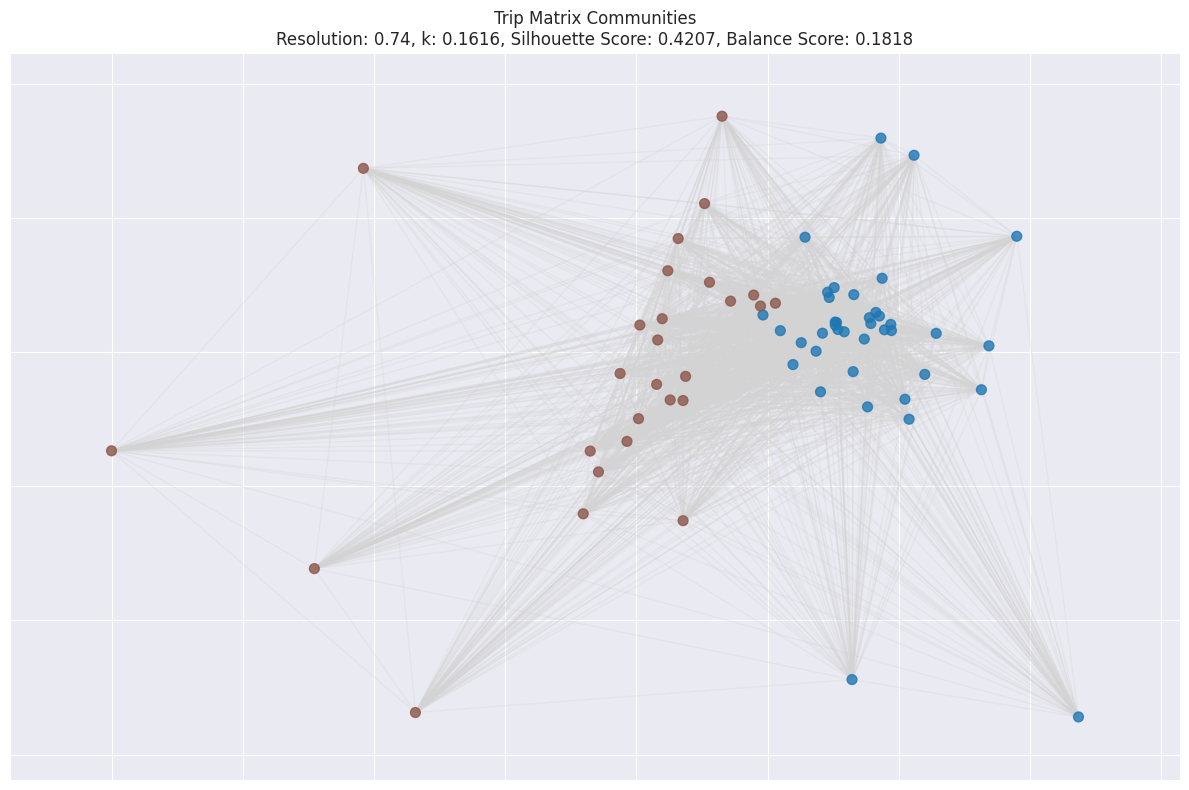

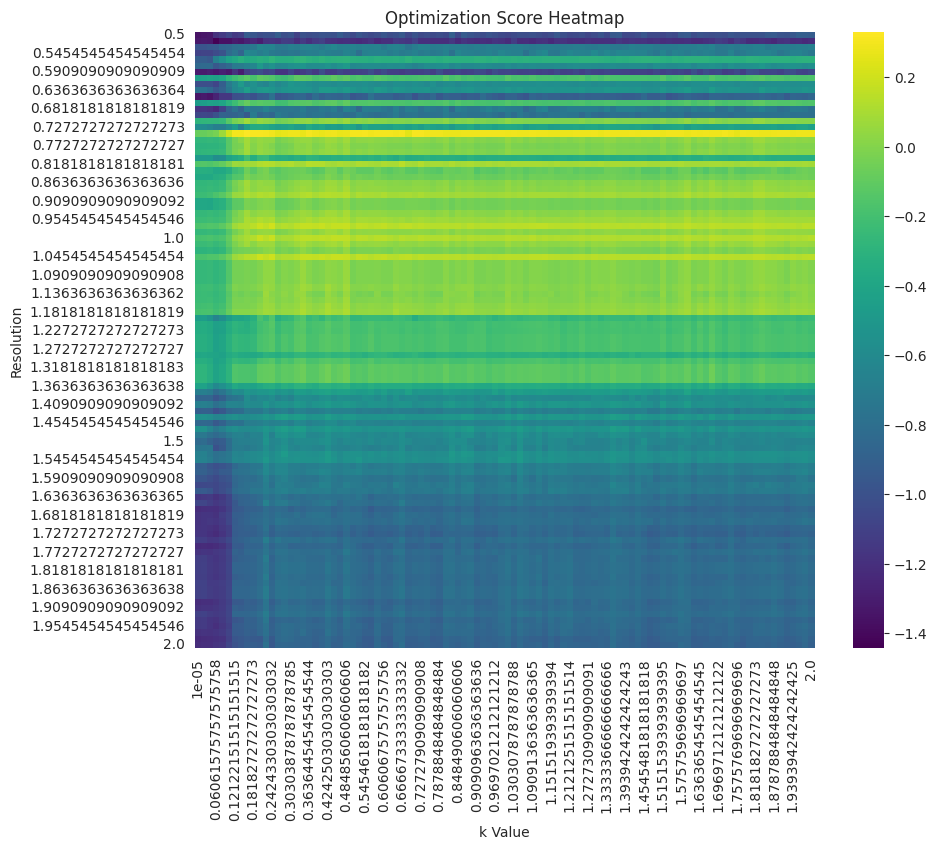

In [87]:
def cluster_balance_score(partition):
    """
    Calculate a cluster balance score.
    
    Parameters:
    -----------
    partition : dict
        Community assignment for each node
    
    Returns:
    --------
    float: Balance score (lower is more balanced)
    """
    # Count nodes in each community
    community_sizes = {}
    for node, community in partition.items():
        if community not in community_sizes:
            community_sizes[community] = 0
        community_sizes[community] += 1
    
    # Calculate size variation
    sizes = list(community_sizes.values())
    mean_size = np.mean(sizes)
    
    # Coefficient of variation (normalized standard deviation)
    # Lower values indicate more balanced clusters
    if mean_size > 0:
        balance_score = np.std(sizes) / mean_size
    else:
        balance_score = float('inf')
    
    return balance_score

def optimize_trip_matrix_community_detection(pivot_matrix, 
                                             resolution_range=(0.5, 2), 
                                             resolution_steps=100, 
                                             k_range=(0.00001, 2),
                                             k_steps=100,
                                             min_clusters=0,
                                             max_clusters=1000,
                                             balance_weight=0.5):
    """
    Optimize community detection on trip matrix using Louvain method
    with added emphasis on cluster balance
    
    Parameters:
    -----------
    pivot_matrix : pandas.DataFrame
        Pivoted trip matrix with locations as index and columns
    resolution_range : tuple, optional
        Range of resolution parameters to test
    resolution_steps : int, optional
        Number of resolution steps to test
    k_range : tuple, optional
        Range of k values to test for Fruchterman-Reingold layout
    balance_weight : float, optional
        Weight given to cluster balance in optimization
    
    Returns:
    --------
    dict : Optimization results including communities, layout, scores, etc.
    """
    # Create weighted graph from pivot matrix
    G = nx.Graph()
    
    # Fill NaN with 0 and convert to numpy array for efficient processing
    trip_array = pivot_matrix.fillna(0).values
    
    # Add nodes (locations)
    locations = pivot_matrix.index.tolist()
    G.add_nodes_from(locations)
    
    # Add weighted edges based on trip counts
    for i, loc1 in enumerate(locations):
        for j, loc2 in enumerate(locations):
            if i != j:  # Avoid self-loops
                weight = trip_array[i, j] + trip_array[j, i]  # Symmetric weight
                if weight > 0:
                    G.add_edge(loc1, loc2, weight=weight)
    
    # Prepare results storage
    best_result = {
        'optimal_resolution': None,
        'optimal_k': None,
        'max_combined_score': float('-inf'),
        'communities': None,
        'pos': None,
        'silhouette_score': None,
        'balance_score': None,
        'scores': []  # To store scores at each step
    }
    
    # Generate resolution parameters
    resolutions = np.linspace(resolution_range[0], resolution_range[1], resolution_steps)
    
    # Iterate over combined steps with a single progress bar
    total_steps = resolution_steps * k_steps
    with tqdm(total=total_steps, desc="Testing resolutions and k values") as pbar:
        for resolution in resolutions:
            # Perform Louvain community detection
            partition = community_louvain.best_partition(G, weight='weight', resolution=resolution)
            
            # Check number of clusters
            num_clusters = len(set(partition.values()))
            if num_clusters < min_clusters or num_clusters > max_clusters:
                pbar.update(k_steps)
                continue
            
            # Convert partition to community labels
            community_labels = np.array([partition[node] for node in G.nodes()])
            
            # Test different k values for Fruchterman-Reingold layout
            for k in np.linspace(k_range[0], k_range[1], k_steps):
                try:
                    # Compute Fruchterman-Reingold layout with edge weights
                    pos = nx.spring_layout(G, k=k, weight='weight', seed=42)
                    
                    # Convert positions to numpy array for silhouette score calculation
                    pos_array = np.array([pos[node] for node in G.nodes()])
                    
                    # Calculate silhouette score
                    silhouette_avg = silhouette_score(pos_array, community_labels)
                    
                    # Calculate cluster balance score
                    balance_score = cluster_balance_score(partition)
                    
                    # Combined optimization score
                    # Higher silhouette score is better
                    # Lower balance score is better (more balanced)
                    combined_score = silhouette_avg - (balance_weight * balance_score)
                    
                    # Store scores at each step
                    best_result['scores'].append({
                        'resolution': resolution,
                        'k': k,
                        'silhouette_score': silhouette_avg,
                        'balance_score': balance_score,
                        'combined_score': combined_score
                    })
                    
                    # Update best result if current is better
                    if combined_score > best_result['max_combined_score']:
                        best_result.update({
                            'optimal_resolution': resolution,
                            'optimal_k': k,
                            'max_combined_score': combined_score,
                            'communities': partition,
                            'pos': pos,
                            'silhouette_score': silhouette_avg,
                            'balance_score': balance_score
                        })
                except Exception as e:
                    # Skip if silhouette score calculation fails
                    print(f"Skipping calculation for resolution {resolution}, k {k}: {e}")
                pbar.update(1)
    
    return best_result

def visualize_trip_communities(G, result):
    """
    Visualize the graph with community detection results
    
    Parameters:
    -----------
    G : networkx.Graph
        Input graph
    result : dict
        Results from optimize_trip_matrix_community_detection
    """
    plt.figure(figsize=(12, 8))
    
    # Get unique community colors
    unique_communities = set(result['communities'].values())
    color_map = plt.colormaps.get_cmap('tab20')
    community_colors = {comm: color_map(i/len(unique_communities)) 
                        for i, comm in enumerate(unique_communities)}
    
    # Color nodes by community
    node_colors = [community_colors[result['communities'][node]] for node in G.nodes()]
    
    # Draw nodes
    nx.draw_networkx_nodes(G, 
                           pos=result['pos'], 
                           node_color=node_colors, 
                           node_size=50,
                           alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(G, 
                           pos=result['pos'], 
                           edge_color='lightgray',
                           alpha=0.3)
    
    # Analyze cluster sizes
    cluster_sizes = {}
    for node, community in result['communities'].items():
        if community not in cluster_sizes:
            cluster_sizes[community] = 0
        cluster_sizes[community] += 1
    
    # Print detailed community information
    print("Community Sizes:")
    for comm, size in sorted(cluster_sizes.items(), key=lambda x: x[1], reverse=True):
        print(f"Community {comm}: {size} nodes")
    
    # Print optimization metrics
    plt.title(f"Trip Matrix Communities\n"
              f"Resolution: {result['optimal_resolution']:.2f}, "
              f"k: {result['optimal_k']:.4f}, "
              f"Silhouette Score: {result['silhouette_score']:.4f}, "
              f"Balance Score: {result['balance_score']:.4f}")
    
    plt.tight_layout()
    plt.show()
    
def visualize_scores(scores):
    """
    Visualize a heatmap of the optimization scores
    
    Parameters:
    -----------
    scores : list of dicts
        Each dict contains 'resolution', 'k', 'silhouette_score', 'balance_score', and 'combined_score'
    """
    # Convert scores to a DataFrame
    df_scores = pd.DataFrame(scores)
    
    # Pivot DataFrame for heatmap
    pivot_scores = df_scores.pivot(index='resolution', columns='k', values='combined_score')
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_scores, cmap='viridis', annot=False, fmt=".2f")
    plt.title("Optimization Score Heatmap")
    plt.xlabel("k Value")
    plt.ylabel("Resolution")
    plt.show()

def create_trip_graph(pivot_matrix):
    """
    Create a weighted networkx graph from a pivot matrix of trips
    
    Parameters:
    -----------
    pivot_matrix : pandas.DataFrame
        Pivoted trip matrix with locations as index and columns
    
    Returns:
    --------
    networkx.Graph: Weighted graph representing trip connections
    """
    # Create an empty graph
    G = nx.Graph()
    
    # Fill NaN with 0 and convert to numpy array for efficient processing
    trip_array = pivot_matrix.fillna(0).values
    
    # Add nodes (locations)
    locations = pivot_matrix.index.tolist()
    G.add_nodes_from(locations)
    
    # Add weighted edges based on trip counts
    for i, loc1 in enumerate(locations):
        for j, loc2 in enumerate(locations):
            if i != j:  # Avoid self-loops
                # Symmetric weight: sum of trips in both directions
                weight = trip_array[i, j] + trip_array[j, i]
                
                if weight > 0:
                    G.add_edge(loc1, loc2, weight=weight)
    
    return G

# Create the graph
G = create_trip_graph(pivot_matrix)

# Perform community detection
result = optimize_trip_matrix_community_detection(pivot_matrix)

# Visualize results
visualize_trip_communities(G, result)

visualize_scores(result['scores'])

In [6]:
def map_network():
    # Ensure GeoDataFrame has an appropriate CRS (WGS 84 for Folium)
    zones = zones.to_crs(epsg=4326)
    
    # Create a colormap
    unique_values = zones['location_count'].unique()
    unique_values.sort()
    norm = mcolors.Normalize(vmin=0, vmax=len(unique_values))
    color_dict = {val: mcolors.rgb2hex(plt.cm.coolwarm(norm(i))) for i, val in enumerate(unique_values)}
    zones['color'] = zones['location_count'].map(color_dict)
    
    # Create the base map centered on Manhattan
    manhattan_map = folium.Map(location=[40.7831, -73.9712], zoom_start=12, tiles='CartoDB positron')
    
    # Add taxi zones (polygons) with tooltips and colors
    folium.GeoJson(
        zones[['geometry', 'zone', 'color']],
        style_function=lambda feature: {
            'fillColor': feature['properties']['color'],
            'color': 'black',
            'weight': 0.5,
            'fillOpacity': 0.7,
        },
        tooltip=folium.GeoJsonTooltip(fields=['zone'], labels=False)  # Tooltip directly on polygons
    ).add_to(manhattan_map)
    
    # Aggregate weights to make the graph undirected
    trip_matrix_undirected = (
        trip_matrix.groupby(
            by=[
                trip_matrix['PULocationID'].combine(trip_matrix['DOLocationID'], min),
                trip_matrix['PULocationID'].combine(trip_matrix['DOLocationID'], max)
            ]
        )['count'].sum().reset_index(name='count')
    )
    
    # Create an undirected graph
    G_undirected = nx.Graph()
    
    # Remove self-loops and calculate self-loop counts
    self_loops = trip_matrix[trip_matrix['PULocationID'] == trip_matrix['DOLocationID']]
    node_sizes = self_loops.groupby('PULocationID')['count'].sum().to_dict()
    values = list(node_sizes.values())
    min_val = min(values)
    max_val = max(values)
    largest = 500
    smallest = 50
    node_sizes_scaled = {key: ((value - min_val) * (largest - smallest) / (max_val - min_val)) + smallest for key, value in node_sizes.items()}
    
    # Add edges without self-loops
    for _, row in trip_matrix_undirected.iterrows():
        if row.iloc[0] != row.iloc[1]:  # Exclude self-loops
            G_undirected.add_edge(row.iloc[0], row.iloc[1], weight=row['count'])
    
    # Set positions for the nodes using a spring layout
    pos = nx.spring_layout(G_undirected, k=0.5, seed=42)
    
    # Map the edges to the Folium map
    for u, v, data in G_undirected.edges(data=True):
        pulocation = zones[zones['zone'] == u].geometry.centroid
        dolocation = zones[zones['zone'] == v].geometry.centroid
        # Directly use the weight value
        normalized_weight = data['weight'] / max(nx.get_edge_attributes(G_undirected, 'weight').values()) * 5
        folium.PolyLine(locations=[pulocation, dolocation],
                        weight=normalized_weight,
                        color='blue',
                        opacity=0.7).add_to(manhattan_map)
    
    manhattan_map
